In [14]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv("./data/household_power_consumption_daily.csv", parse_dates=True, index_col=0)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800


In [3]:
def to_series(input_data: numpy):
    series_value = [week[:, 0] for week in input_data]

    series_value = numpy.array(series_value).flatten()
    return series_value

def split_data(data):
    train, test = data[1: -328], data[-328:-6]
    train = numpy.array(numpy.split(train, len(train)/7))
    test = numpy.array(numpy.split(test, len(test)/7))
    return train, test

In [8]:
train, test = split_data(df.values)
train_series = to_series(train)

/home/vhyne/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


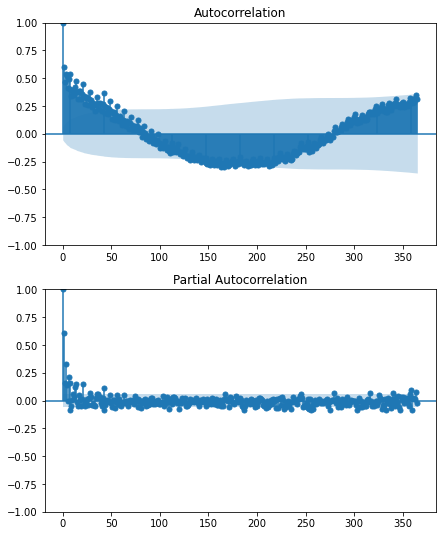

In [9]:
plot_functions = [plot_acf, plot_pacf]
plt.figure(figsize=(7,9))
for i in range(len(plot_functions)):
    ax = plt.subplot(2, 1, i + 1)
    plot_functions[i](train_series, ax=ax, lags=365)
plt.show()

/home/vhyne/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


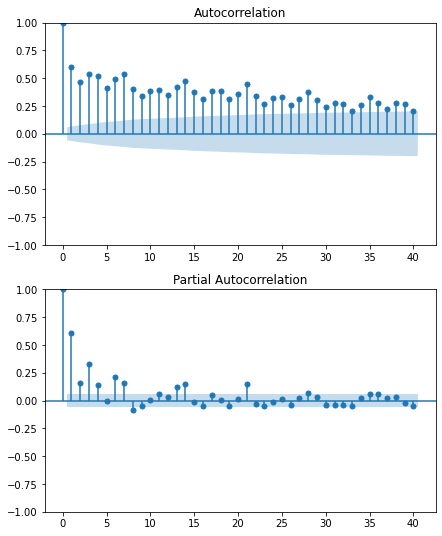

In [10]:
plot_functions = [plot_acf, plot_pacf]
plt.figure(figsize=(7,9))
for i in range(len(plot_functions)):
    ax = plt.subplot(2, 1, i + 1)
    plot_functions[i](train_series, ax=ax, lags=40)
plt.show()

In [11]:
def rmse_evaluation(actual: numpy, predicted: numpy):
    scores = list()

    for i in range(actual.shape[1]):
        rmse = numpy.sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = numpy.sqrt(s/(actual.shape[0] * actual.shape[1]))
    return score, scores

def model_prediction(model, train: numpy, test: numpy):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model(history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    return predictions

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model(history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    score, scores = rmse_evaluation(test[:,:,0], predictions)
    return score, scores

def sunnarize_scores(name, score, scores):
    n_scores = ", ".join(["%.1f"%s for s in scores ])
    print("%s: {%.3f} %s" % (name, score, n_scores))

In [30]:
def arima_model_forecast(data):
    data = to_series(data)
    model = ARIMA(data, order=(6,0,0)).fit()

    yhat = model.predict(len(data), len(data) + 6)
    return yhat

def model_prediction(model, train: numpy, test: numpy):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model(history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    return predictions

In [18]:
arima_predictions = model_prediction(arima_model_forecast, train, test)
test_series = to_series(test)

In [19]:
arima_predictions.shape, test_series.shape

((46, 7), (322,))

In [21]:
arima_series = numpy.reshape(arima_predictions, (322,))

In [22]:
arima_series.shape

(322,)

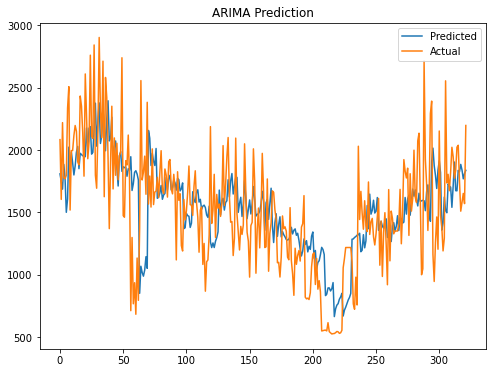

In [26]:
plt.figure(figsize=(8,6))
plt.plot(arima_series, label="Predicted")
plt.plot(test_series, label="Actual")
plt.title("ARIMA Prediction")
plt.legend()
plt.show()

arima: {379.546} 379.9, 394.4, 352.7, 375.1, 389.5, 312.6, 440.4


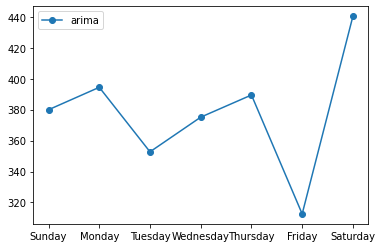

In [31]:
model_dict = dict()

model_dict['arima'] = arima_model_forecast

days = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
for name, funct in model_dict.items():

    score, scores = evaluate_model(funct, train, test)

    sunnarize_scores(name, score,scores)

    plt.plot(days, scores, marker='o', label=name)
plt.legend()
plt.show()